In [1]:
# import pip

In [2]:
# pip.main(['install','/home/nitesh/fastText/.'])

Processing /home/nitesh/fastText
  Using cached https://files.pythonhosted.org/packages/12/90/0f92a575dc60c8fba6d0c91d6b45abdb1058da9ebed40400cbcfad2ac0a7/pybind11-2.2.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8c/10/79282747f9169f21c053c562a0baa21815a8c7879be97abd930dbcf862e8/setuptools-39.1.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7b/61/11b05cc37ccdaabad89f04dbdc2a02905cf6de6f9b05816dba843beed328/numpy-1.14.3-cp35-cp35m-manylinux1_x86_64.whl
  Running setup.py install for fasttext: started
    Running setup.py install for fasttext: finished with status 'done'


You are using pip version 8.1.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


0

In [1]:
import numpy as np
import pip
import torch
from torch import nn
import fastText
import argparse
from torch.autograd import Variable
import io
# import torch
print(torch.__version__)

0.4.0


In [2]:
# parser = argparse.ArgumentParser()
# parser.add_argument('--dis_hidden_dim', type=int, default=2048, help='dimension of hidden state')
# parser.add_argument('--dis_dropout',type=float, default=0.5, help='dropout value')
# parser.add_argument('--dis_input_dropout', type=float, default=0.3, help='Point Number [default: 1024]')

# params=parser.parse_args()
def load_vec(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

def load_fasttext_model(path):
    """
    Load a binarized fastText model.
    """
    try:
        import fastText
    except ImportError:
        raise Exception("Unable to import fastText. Please install fastText for Python: "
                        "https://github.com/facebookresearch/fastText")
    return fastText.load_model(path)

In [3]:
# english.get
# src_embeddings, src_id2word, src_word2id = load_vec(src_path, nmax)
# tgt_embeddings, tgt_id2word, tgt_word2id = load_vec(tgt_path, nmax)

In [3]:

english=load_fasttext_model("/home/nitesh/wordembeddings/data/wiki.en.bin")
spanish=load_fasttext_model("/home/nitesh/wordembeddings/data/wiki.es.bin")
words = english.get_labels()
english_embeddings = torch.from_numpy(np.concatenate([english.get_word_vector(w)[None] for w in words], 0))[:30000]
spanish_words = spanish.get_labels()
spanish_embeddings = torch.from_numpy(np.concatenate([spanish.get_word_vector(w)[None] for w in Swords], 0))[:30000]

In [10]:
def get_batch2(X,M):
    '''
    get batch for pytorch model
    '''
    # TODO fix and make it nicer, there is pytorch forum question
    #X,Y = X.data.numpy(), Y.data.numpy()
#     X,Y = X, Y
    N = X.size()[0]
    N=30000
    batch_indices = torch.LongTensor( np.random.randint(0,N,size=M) )
#     print(batch_indices)
    batch_xs = torch.index_select(X,0,batch_indices)
#     batch_ys = torch.index_select(Y,0,batch_indices)
    return Variable(batch_xs, requires_grad=False).cuda()

In [5]:
class Discriminator(nn.Module):

    def __init__(self, dis_hid_dim,dis_dropout,dis_input_dropout):
        super(Discriminator, self).__init__()

        self.emb_dim = 300
        self.dis_layers = 3
        self.dis_hid_dim = dis_hid_dim
        self.dis_dropout = dis_dropout
        self.dis_input_dropout = dis_input_dropout

        layers = [nn.Dropout(self.dis_input_dropout)]
        for i in range(self.dis_layers + 1):
            input_dim = self.emb_dim if i == 0 else self.dis_hid_dim
            output_dim = 1 if i == self.dis_layers else self.dis_hid_dim
            layers.append(nn.Linear(input_dim, output_dim))
            if i < self.dis_layers:
                layers.append(nn.LeakyReLU(0.2))
                layers.append(nn.Dropout(self.dis_dropout))
        layers.append(nn.Sigmoid())
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        assert x.dim() == 2 and x.size(1) == self.emb_dim
        return self.layers(x).view(-1)

In [6]:

def Orthogonal(mapping,beta):
    W=mapping.weight.data
#     print(type(W))
  
    mapping.weight.data.copy_((1 + beta) * W - beta * W.mm(W.transpose(0, 1).mm(W)))
#     print(mapping.weight.data.transpose(0, 1).mm(W))
    
    return mapping


In [7]:
#set up linear mapping,
mapping = nn.Linear(300, 300, bias=False)
mapping.weight.data.copy_(torch.eye(300))
modelDisc= Discriminator(2048,0.3,0.1)
mapping.cuda()
modelDisc.cuda()

Discriminator(
  (layers): Sequential(
    (0): Dropout(p=0.1)
    (1): Linear(in_features=300, out_features=2048, bias=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.3)
    (4): Linear(in_features=2048, out_features=2048, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Dropout(p=0.3)
    (7): Linear(in_features=2048, out_features=2048, bias=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Dropout(p=0.3)
    (10): Linear(in_features=2048, out_features=1, bias=True)
    (11): Sigmoid()
  )
)

In [8]:
linoptimizer = torch.optim.SGD(mapping.parameters(), lr=0.1)
discoptimizer= torch.optim.SGD(modelDisc.parameters(), lr=0.1)
# torch.optim.
loss_fn=torch.nn.BCELoss()

def get_xy():
#get minibatch of spanish words
    spanish_batch=get_batch2(spanish_embeddings,batch_size)
    #getminibatch of english words
    english_batch=get_batch2(english_embeddings,batch_size)

    #generate fake spanish embeddings
    s_fake= mapping(english_batch)

    #stack real and fake
    x = torch.cat([spanish_batch, s_fake], 0)
    #         print(x.shape)
    y = torch.FloatTensor(2 * batch_size).zero_().cuda()

    y[batch_size:] = 0.05
    y[:batch_size]=1-0.05
    return x,y

In [11]:
epoch=1000
batch_size=32
# E_batch=Batch(english_embeddings)
# S_batch=Batch(spanish_embeddings)
dog=Variable(english_embeddings[english.get_word_id('dog')]).cuda()

perro=spanish_embeddings[spanish.get_word_id('perro')]
for _ in range(epoch):
      
    
    modelDisc.train()
    mapping.eval()
    for __ in range(5):
        
        x,y=get_xy()
        y_pred = modelDisc(x)
        # Compute and print loss.
        

        loss= loss_fn(y_pred, y)

        discoptimizer.zero_grad()
       
        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()
#         print(loss.data)

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        discoptimizer.step()
        
        
    for __ in range(3):
        modelDisc.eval()
        mapping.train()
        x,y=get_xy()
        y=1-y
        y_pred = modelDisc(x)
        loss2= loss_fn(y_pred, y)
        linoptimizer.zero_grad()
        loss2.backward()
        linoptimizer.step()
        
        if _%1:
            mapping=Orthogonal(mapping,0.001)
        cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    #     print(type(perro),type(mapping(dog).cpu()))
    print(cos(perro.cpu(),mapping(dog).cpu()))
    
    
    

tensor(1.00000e-02 *
       6.3916)
tensor(1.00000e-02 *
       6.4300)
tensor(1.00000e-02 *
       6.4939)
tensor(1.00000e-02 *
       6.5872)
tensor(1.00000e-02 *
       6.7189)
tensor(1.00000e-02 *
       6.9257)
tensor(1.00000e-02 *
       7.2339)
tensor(1.00000e-02 *
       7.6949)
tensor(1.00000e-02 *
       8.4691)
tensor(1.00000e-02 *
       9.4950)
tensor(0.1129)
tensor(0.1344)
tensor(0.1588)
tensor(0.1782)
tensor(0.1919)
tensor(0.2018)
tensor(0.2105)
tensor(0.2177)
tensor(0.2230)
tensor(0.2274)
tensor(0.2307)
tensor(0.2332)
tensor(0.2352)
tensor(0.2364)
tensor(0.2366)
tensor(0.2361)
tensor(0.2350)
tensor(0.2333)
tensor(0.2308)
tensor(0.2278)
tensor(0.2244)
tensor(0.2207)
tensor(0.2171)
tensor(0.2130)
tensor(0.2088)
tensor(0.2048)
tensor(0.2007)
tensor(0.1966)
tensor(0.1927)
tensor(0.1891)
tensor(0.1854)
tensor(0.1826)
tensor(0.1802)
tensor(0.1782)
tensor(0.1770)
tensor(0.1763)
tensor(0.1765)
tensor(0.1778)
tensor(0.1797)
tensor(0.1823)
tensor(0.1856)
tensor(0.1890)
tensor(0.1

tensor(0.1956)
tensor(0.1934)
tensor(0.1842)
tensor(0.1791)
tensor(0.1782)
tensor(0.1896)
tensor(0.1967)
tensor(0.2021)
tensor(0.2034)
tensor(0.2017)
tensor(0.1995)
tensor(0.2008)
tensor(0.1993)
tensor(0.1916)
tensor(0.1874)
tensor(0.1823)
tensor(0.1791)
tensor(0.1835)
tensor(0.1833)
tensor(0.1919)
tensor(0.1957)
tensor(0.1952)
tensor(0.1935)
tensor(0.1943)
tensor(0.1998)
tensor(0.2002)
tensor(0.1928)
tensor(0.1807)
tensor(0.1740)
tensor(0.1820)
tensor(0.1859)
tensor(0.1870)
tensor(0.1923)
tensor(0.1894)
tensor(0.1839)
tensor(0.1679)
tensor(0.1781)
tensor(0.1874)
tensor(0.1977)
tensor(0.2016)
tensor(0.2034)
tensor(0.1998)
tensor(0.2015)
tensor(0.1882)
tensor(0.1767)
tensor(0.1711)
tensor(0.1809)
tensor(0.1938)
tensor(0.2045)
tensor(0.2032)
tensor(0.2071)
tensor(0.1986)
tensor(0.1894)
tensor(0.1785)
tensor(0.1695)
tensor(0.1677)
tensor(0.1653)
tensor(0.1733)
tensor(0.1781)
tensor(0.1866)
tensor(0.1948)
tensor(0.1999)
tensor(0.1991)
tensor(0.1954)
tensor(0.1987)
tensor(0.1990)
tensor(0.1

In [11]:
# # spanish_embeddings
# tgt_emb=spanish_embeddings.numpy()
# # print(tgt_emd.shape)


# def get_nn(word_emb, tgt_emb, tgt_id2word, K=5):
  
#     scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
#     k_best = scores.argsort()[-K:][::-1]
#     for i, idx in enumerate(k_best):
#         print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))

In [12]:
# def create_map(words,language):
#     id2word={}
#     for word in words:
#         id=language.get_word_id(word)
#         id2word[id]=word
#     return id2word
# spanish_map=create_map(Swords,spanish)
        

In [14]:
# cat_embedding=mapping(Variable(english_embeddings[english.get_word_id('cat')],requires_grad=False).cuda()).cpu()
# word_emd=cat_embedding.detach().numpy()
# get_nn(word_emd,tgt_emb,spanish_map)


0.4932 - parlanchín
0.4928 - gaturrín
0.4913 - cachavacha
0.4903 - ratoncito
0.4863 - gato


In [12]:
src_embeddings=mapping(Variable(english_embeddings, requires_grad=False).cuda())
tgt_embeddings=spanish_embeddings.cuda()

In [16]:
# src_embedding=src_embeddings.cpu().detach().numpy()
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2, whiten=True)  # TSNE(n_components=2, n_iter=3000, verbose=2)
# pca.fit(np.vstack([src_embedding, spanish_embeddings]))
# print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

In [20]:
# import matplotlib.pyplot as plt


# def plot_similar_word(src_words, src, src_emb, tgt_words, tgt, tgt_emb, pca):

#     Y = []
#     word_labels = []
#     for sw in src_words:
#         Y.append(src_emb[src.get_word_id(sw)])
#         word_labels.append(sw)
#     for tw in tgt_words:
#         Y.append(tgt_emb[tgt.get_word_id(tw)])
#         word_labels.append(tw)

#     # find tsne coords for 2 dimensions
#     Y = pca.transform(Y)
#     x_coords = Y[:, 0]
#     y_coords = Y[:, 1]

#     # display scatter plot
#     plt.figure(figsize=(10, 8), dpi=80)
#     plt.scatter(x_coords, y_coords, marker='x')

#     for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
#         color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
#         plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
#                      color=color, weight='bold')

#     plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
#     plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
#     plt.title('Visualization of the multilingual word embedding space')

#     plt.show()
    

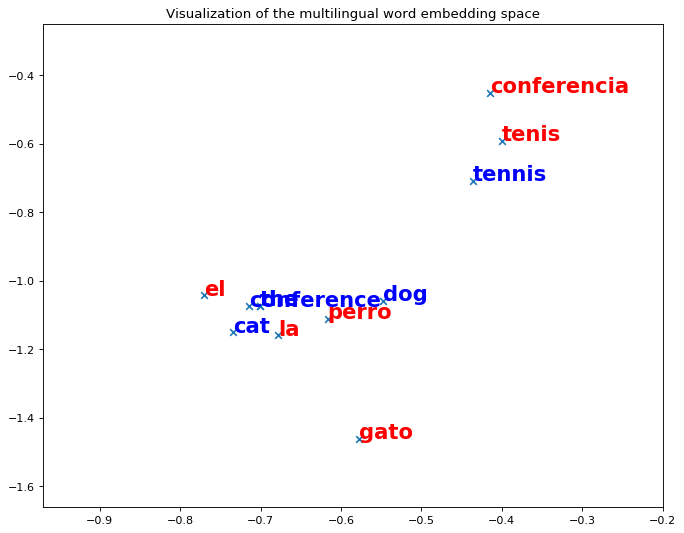

In [21]:
# src_words = ['dog', 'the', 'the', 'tennis', 'cat', 'conference']
# tgt_words = ['perro', 'el', 'la', u'tenis',  'gato', 'conferencia']

# plot_similar_word(src_words,english,english_embeddings.cpu().detach().numpy(),tgt_words,spanish,spanish_embeddings.cpu().detach().numpy(),pca)
# # english.get_word_id

In [23]:
def get_nn_avg_dist(emb, query, knn=10):
    """
    Compute the average distance of the `knn` nearest neighbors
    for a given set of embeddings and queries.
    Use Faiss if available.
    """
    
    bs = 1024
    all_distances = []
    emb = emb.transpose(0, 1).contiguous()
    for i in range(0, query.shape[0], bs):
        distances = query[i:i + bs].mm(emb)
        best_distances, _ = distances.topk(knn, dim=1, largest=True, sorted=True)
        all_distances.append(best_distances.mean(1).cpu())
    all_distances = torch.cat(all_distances)
    return all_distances.detach().numpy()

def get_candidates(emb1,emb2):
    bs = 128

    all_scores = []
    all_targets = []

    # number of source words to consider
    n_src = emb1.size(0)
    n_src =15000
    knn = 10

        # average distances to k nearest neighbors
    average_dist1 = torch.from_numpy(get_nn_avg_dist(emb2, emb1, knn))
    average_dist2 = torch.from_numpy(get_nn_avg_dist(emb1, emb2, knn))
    average_dist1 = average_dist1.type_as(emb1)
    average_dist2 = average_dist2.type_as(emb2)

    # for every source word
    for i in range(0, n_src, bs):

        # compute target words scores
        scores = emb2.mm(emb1[i:min(n_src, i + bs)].transpose(0, 1)).transpose(0, 1)
        scores.mul_(2)
        scores.sub_(average_dist1[i:min(n_src, i + bs)][:, None] + average_dist2[None, :])
        best_scores, best_targets = scores.topk(2, dim=1, largest=True, sorted=True)

        # update scores / potential targets
        all_scores.append(best_scores.cpu())
        all_targets.append(best_targets.cpu())

    all_scores = torch.cat(all_scores, 0)
    all_targets = torch.cat(all_targets, 0)

    all_pairs = torch.cat([torch.arange(0, all_targets.size(0)).long().unsqueeze(1),all_targets[:, 0].unsqueeze(1)], 1)
    assert all_scores.size() == all_pairs.size() == (n_src, 2)

    # sort pairs by score confidence
    diff = all_scores[:, 0] - all_scores[:, 1]
    reordered = diff.sort(0, descending=True)[1]
    all_scores = all_scores[reordered]
    all_pairs = all_pairs[reordered]
    
    
    selected = all_pairs.max(1)[0] <= 15000
    mask = selected.unsqueeze(1).expand_as(all_scores).clone()
    all_scores = all_scores.masked_select(mask).view(-1, 2)
    all_pairs = all_pairs.masked_select(mask).view(-1, 2)
    return all_pairs


In [31]:

def create_dictionary(src_embedding,tgt_embedding):
    src2tgt = get_candidates(src_embedding,tgt_embedding)
    tgt2src = get_candidates(tgt_embedding,src_embedding)
    
    s2t_candidates = set([(a, b) for a, b in src2tgt])
    t2s_candidates = set([(a, b) for a, b in tgt2src])
    print(s2t_candidates)
    final_pairs = s2t_candidates & t2s_candidates
    if len(final_pairs) == 0:
        print("warning")
        return None
    dico = torch.LongTensor(list([[a, b] for (a, b) in final_pairs]))

    print('New train dictionary of %i pairs.' % dico.size(0))
    return dico.cuda()
    
        
    

In [32]:
create_dictionary(src_embeddings,tgt_embeddings)
# print(type(src_embedding))

{(tensor(4740), tensor(3699)), (tensor(2767), tensor(1225)), (tensor(6839), tensor(2429)), (tensor(235), tensor(11202)), (tensor(6328), tensor(8890)), (tensor(11784), tensor(11616)), (tensor(6949), tensor(10719)), (tensor(11679), tensor(13417)), (tensor(8405), tensor(12398)), (tensor(12925), tensor(8935)), (tensor(5234), tensor(314)), (tensor(6926), tensor(8656)), (tensor(6709), tensor(5264)), (tensor(11783), tensor(4925)), (tensor(9819), tensor(2303)), (tensor(12818), tensor(9440)), (tensor(9767), tensor(8534)), (tensor(8299), tensor(6190)), (tensor(4619), tensor(4820)), (tensor(7793), tensor(9957)), (tensor(4073), tensor(14265)), (tensor(8656), tensor(3822)), (tensor(6488), tensor(13071)), (tensor(6548), tensor(12523)), (tensor(12621), tensor(1247)), (tensor(13279), tensor(9633)), (tensor(3815), tensor(13870)), (tensor(14234), tensor(4956)), (tensor(3001), tensor(13071)), (tensor(8641), tensor(5792)), (tensor(4853), tensor(14343)), (tensor(11028), tensor(8137)), (tensor(10647), tenso